In [1]:
#importing the contest dataset
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1ZKrbsUlrsTgJSlFMz2EGmTINFCQ8PcjO',
dest_path='content/concrete_crack_data.zip',
unzip=True)

Unzipping...Done.


In [2]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 9.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=dec6584adba75f0eb7a91542aac6219d2f7942bcbf7d97a8bd22659d8aa82aab
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=812dbd088fdbd50c492904aab25bfc04cb238fce67455e28a80bd358f073e242
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os

In [4]:
data=[]
img_size=50 # Here we are taking image size as 50, but it's completely dependent on the user. I experimented and it gave me the best results
def create_data():
    for item in ['Negative','Positive']:
      path='/content/content/concrete_cracked_images/train/'+item+"/"

      for img in os.listdir(path): # os.listdir gets you all the list of name of files located in the given path
        try:
          img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE) # converts the image to pixels and gray scales the images
          new_img_array=cv2.resize(img_array,(img_size,img_size)) # resizing the images
          #converting the images into rgb format so that transfer learning can take place
          new_img_array=np.dstack((new_img_array, new_img_array, new_img_array))
          #appending 0 if there's no crack  and 1 if crack is present
          if item == 'Negative':
            data.append([new_img_array,0])
          else:
            data.append([new_img_array, 1]) 
        except Exception as e:
          pass # try and except is exception handling case in python, saves you from getting errors


create_data()

In [5]:
len(data)

28718

In [6]:
np.random.shuffle(data)
x,y = [],[]
for image in data:
  x.append(image[0])
  y.append(image[1])
# creating y as a dummy variable and converting x & y to numpy array as they are lists
y = pd.get_dummies(y)
x = np.array(x)
y = np.array(y)
np.unique(y, return_counts=True)

(array([0, 1], dtype=uint8), array([28718, 28718]))

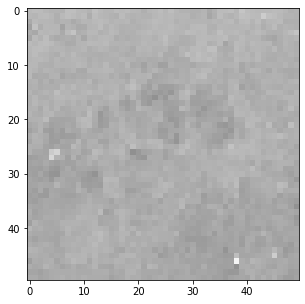

In [7]:
#displaying an instance of the image
plt.figure(figsize = (5,5))
plt.imshow(data[0][0], cmap='gray')
#plt.title(l[0])
plt.show()

In [8]:

img_size = 50
#train test split is done
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=.12, random_state=40)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
# Normalize the data for better results
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
print(x_train.shape,x_test.shape)
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
print(x_train.shape)
y_train = np.array(y_train)
x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)
print(x_test.shape)

(25271, 50, 50, 3) (25271, 2) (3447, 50, 50, 3) (3447, 2)
(25271, 50, 50, 3) (3447, 50, 50, 3)
(25271, 50, 50, 3)
(3447, 50, 50, 3)


In [25]:
#This function defines two pretrained models VGG-16 and ResNets which don't need to be trained further
def transfer_learning(model):
    for layer in model.layers:
        layer.trainable = False
#vgg model        
model_vgg = VGG16(include_top=False,weights='imagenet',pooling='avg')
#resnet model
model_resnet = ResNet50(include_top=False,weights='imagenet',pooling='avg')
# transfer_learning(model_vgg)
# transfer_learning(model_resnet)

models = [model_vgg,model_resnet]
model_name = ["VGG","RESNET"]

In [26]:
from keras.models import Model
import time
#Model Training
def training_model(para):
    model = para;
    x = model.output
    #A dense layer has been added because we want two outputs 
    y = Dense(2,activation='softmax')(x)
    final_model = Model(inputs=model.input,outputs=y)
     #defining the optimizer   
    opt = SGD(lr=0.001, momentum=0.9, nesterov=True)
    final_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    t1=time.time()
    final_model.fit(x_train, y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),shuffle=True,verbose=1)
    #training is done for 6th and above layers 
    for layer in final_model.layers[6:]:
        layer.trainable = True
    final_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    t2=time.time()
    print('The time taken to train the model is',round(int(t2-t1)/60,2),'minutes')
    scores = final_model.evaluate(x_test, y_test,batch_size=32)
    print("Loss"+ str(scores[0]))
    print("Accuracy"+ str(scores[1]))
    return final_model    

In [27]:
#Training the VGG Model
print("training VGG")
vgg=training_model(model_vgg)

training VGG
Epoch 1/10
790/790 [==============================] - 35s 43ms/step - loss: 0.0768 - accuracy: 0.9739 - val_loss: 0.0217 - val_accuracy: 0.9933
Epoch 2/10
790/790 [==============================] - 34s 43ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.0108 - val_accuracy: 0.9980
Epoch 3/10
790/790 [==============================] - 33s 42ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0242 - val_accuracy: 0.9927
Epoch 4/10
790/790 [==============================] - 34s 43ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0086 - val_accuracy: 0.9977
Epoch 5/10
790/790 [==============================] - 34s 42ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0107 - val_accuracy: 0.9965
Epoch 6/10
790/790 [==============================] - 34s 42ms/step - loss: 0.0045 - accuracy: 0.9983 - val_loss: 0.0098 - val_accuracy: 0.9977
Epoch 7/10
790/790 [==============================] - 34s 43ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0075 - 

In [ ]:
#Training the ResNet Model Model
print("training Resnet")
resnet=training_model(model_resnet)

training Resnet
Epoch 1/8
790/790 - 37s - loss: 0.0451 - accuracy: 0.9847 - val_loss: 1.8039 - val_accuracy: 0.5622
Epoch 2/8
790/790 - 33s - loss: 0.0126 - accuracy: 0.9964 - val_loss: 0.0116 - val_accuracy: 0.9977
Epoch 3/8
790/790 - 33s - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.0107 - val_accuracy: 0.9974
Epoch 4/8
790/790 - 33s - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0112 - val_accuracy: 0.9977
Epoch 5/8
790/790 - 33s - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0090 - val_accuracy: 0.9983
Epoch 6/8
790/790 - 33s - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0123 - val_accuracy: 0.9977
Epoch 7/8
790/790 - 33s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0148 - val_accuracy: 0.9983
Epoch 8/8
790/790 - 33s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0146 - val_accuracy: 0.9980
The time taken to train the model is 4.5 minutes
108/108 [==============================] - 3s 12ms/step - loss: 0.0143 - accuracy: 0.9978
Loss0.014600037597119808
Accuracy0.9979692697

### **VGG Model seemed to perform better, hence I used that model**

In [28]:
#class prediction for test data
predictions_vgg = np.argmax(vgg.predict(x_test), axis=-1)
predictions_vgg[:15]

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1])

In [29]:
#display classification report for each of the classes
print(classification_report(np.argmax(y_test,axis = 1), predictions_vgg, target_names = ['Negative (Class 0)','Positive (Class 1)']))

                    precision    recall  f1-score   support

Negative (Class 0)       1.00      1.00      1.00      1727
Positive (Class 1)       1.00      1.00      1.00      1720

          accuracy                           1.00      3447
         macro avg       1.00      1.00      1.00      3447
      weighted avg       1.00      1.00      1.00      3447



[Text(69.0, 0.5, 'Predicted Outcome'), Text(0.5, 69.0, 'Actual Outcome')]

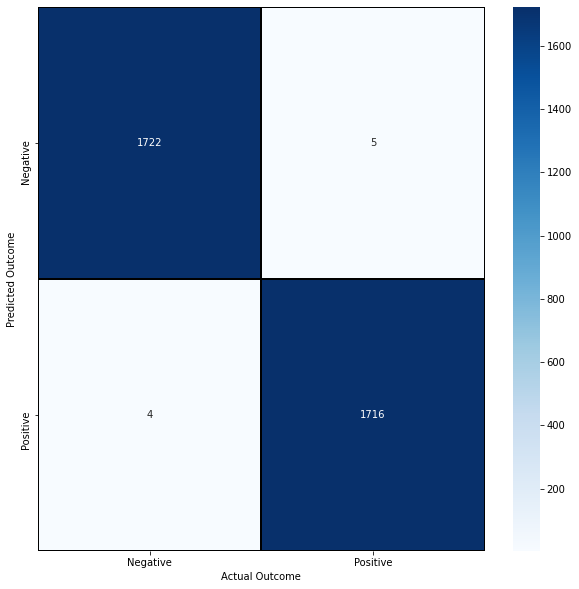

In [30]:
#to plot a confusion matrix
cm=confusion_matrix(np.argmax(y_test, axis=-1), predictions_vgg)
cm1 = pd.DataFrame(cm , index = ['Negative','Positive'] , columns = ['Negative','Positive'])
plt.figure(figsize = (10,10))
ax=sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
ax.set(xlabel="Actual Outcome", ylabel = "Predicted Outcome")

In [31]:
# Loading the order of the image's name that has been provided
test_image_order = pd.read_csv("/content/content/concrete_cracked_images/Testing_set_concrete_crack.csv")
test_image_order.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [32]:
#appending the test image files
file_paths = [[fname, '/content/content/concrete_cracked_images/test/' + fname] for fname in test_image_order['filename']]

In [33]:
# Confirm if number of images is same as number of labels given
if len(test_image_order) == len(file_paths):
  print('Number of image names i.e. ', len(test_image_order), 'matches the number of file paths i.e. ', len(file_paths))
else:
  print('Number of image names does not match the number of filepaths')

Number of image names i.e.  11282 matches the number of file paths i.e.  11282


In [34]:
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/concrete_cracked_images/test/...
1,Image_2.jpg,/content/content/concrete_cracked_images/test/...
2,Image_3.jpg,/content/content/concrete_cracked_images/test/...
3,Image_4.jpg,/content/content/concrete_cracked_images/test/...
4,Image_5.jpg,/content/content/concrete_cracked_images/test/...


In [35]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 50 # image size taken is 50 here as was for training. one can take other size too
for i in range(len(test_images)):
    img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale
    new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
    new_img_array=np.dstack((new_img_array, new_img_array, new_img_array)) #since model is trained in rgb format
    test_pixel_data.append(new_img_array)

In [36]:
#converting into a numpy array
test_pixel_data = np.array(test_pixel_data)
#Normalization as done in the training set
test_pixel_data=test_pixel_data/255
test_pixel_data=test_pixel_data.reshape(-1, img_size, img_size, 3)
test_pixel_data.shape

(11282, 50, 50, 3)

In [37]:
#prediction by the model
pred=np.argmax(vgg.predict(test_pixel_data), axis=-1)
pred[:15]

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1])

In [38]:
pred.sum()

5117

In [39]:
prediction = []
#appending Negative for 0 and Positive for 1 in prediction array
for value in pred:
  if value ==0:
    prediction.append("Negative")
  else:
    prediction.append("Positive")

In [ ]:
res = pd.DataFrame({'prediction': prediction}) # prediction is nothing but the final predictions of my model on input features of new unseen test data
res.to_csv("submission.csv", index = False)
# To download the csv file locally
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>